# PageRank 

Before we discuss the PageRank algorithm, let's take a quick look at its history and what motivated its creation.

## Early Search Engines

Early approaches to search engines involved crawling web pages and then listing terms that appeared and storing them in an *inverted index*, a data structure that allows locating all places *pointed to* by a term. 

When a *search query* is given:
* terms are extracted from the search query
* pages are pointed to by the terms are retrieved
* pages are ranked according to
    * how the terms were used in the page (e.g. terms appearing in headers have more importance)
    * how frequent those terms appeared in the page

## Term Spam

Some unethical people saw the opportunity of fooling search engines to direct users to their site (a sort of free advertisement).  For example, if they want to direct users searching for 'movie' to their site, they would do the following:
* Add a *lot* of occurances of the term 'movie' to their site (with font color similar to page's background to hide the text)
* Do a search for *movie* and copy contents of the highest-ranked page (again, using the "invisible text" approach above).
This technique for fooling a search engine into believing that a page is something that it is not is called *term spam*.

## Introducing Page Rank

To combat term spam, Google introduced two innovations:
* They introduced PageRank to assess the importance of pages
    - A simulation of Web surfers, starting at a random page, randomly following outlinks in each page they visit. Process iterates many times. 
    - The pages visited more often by the surfers are considered more important
* Pages were judged not only by the terms that appeared in them, but by the *terms used in the link* (the anchor text), and the terms near the links to that page.

## Graph Notations

To illustrate how PageRank and other Link Analysis algorithms work, it is useful to think of the Web as a directed graph with the following characteristics:
* **nodes** represent pages
* **arcs** represent links from one page to another 

## Defining and Displaying Graphs with NetworkX

A useful package for defining and displaying graphs in python is NetworkX. Below is an illustration of how we create a directed graph by defining the graph's nodes and edges. We then show the graph with a call to the `draw` command.

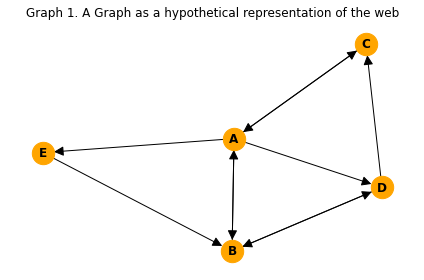

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

G1 = nx.DiGraph()
G1.add_nodes_from(["A","B","C","D","E"])
G1.add_edges_from([
    ("A","B"), ("A","C"), ("A","D"), ("A","E"), 
    ("B","A"), ("B","D"), 
    ("C","A"),    
    ("D","B"), ("D","C"),
    ("E","B"),
])

plt.figure()  
plt.title("Graph 1. A Graph as a hypothetical representation of the web")
nx.draw(G1, node_size=500, node_color='orange', with_labels=True, font_weight='bold', arrowsize=20)
plt.tight_layout()
plt.show()

## Adjacency Matrix

The **Adjacency Matrix** is a representation showing which vertices are adjacent, i.e., connected by edges or links. Formally, if $A$ is the adjacency matrix of a graph $G$, and $a_{ij}$ are the elements of $A$, 
$a_{ij}=1$ if there is a link from node $i$ to node $j$, otherwise, $a_{ij}=0$.

In the discussion later on Hubs and Authorities, this matrix will also be known as the **Link Matrix**. It represents the existence of outgoing links from one page to another.

In NetworkX, the adjacency matrix can be computed using the `adjacency_matrix` function. This produces a sparse matrix. We can convert this to a dense matrix by calling the `toarray` method.

In [2]:
A = nx.adjacency_matrix(G1).toarray()
A

array([[0, 1, 1, 1, 1],
       [1, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 0, 0, 0]])

## Transition Matrix

In the computation of PageRank, an important data structure is the **Transition Matrix**.

Recall the idea of a surfer randomly browsing through the Web. Given graph $G1$, our hypothetical representation of the Web in Figure 1, if the surfer is at page A, the following are the probabilities of the next page he will visit:
* page A: 0
* page B: 1/4
* page C: 1/4
* page D: 1/4
* page E: 1/4

We can do the same for all other nodes and define a *Transition Matrix* to represent the the probabilities of where this surfer would go next, for any starting location in the Web. 

To generate the Transition Matrix from a graph, we will need the *transpose* of its Adjacency Matrix as well as a vector of its out degrees (the number of links coming out from a node or page) . We have already computed for $G1$'s adjacency matrix and stored it in $A$; to get the outlinks of the nodes, we can use the graph's `out_degree` method: 

In [3]:
G1.out_degree

OutDegreeView({'A': 4, 'B': 2, 'C': 1, 'D': 2, 'E': 1})

We then convert this into an numpy array, getting only the values of the outdegrees:

In [4]:
import numpy as np

d = np.array([x[1] for x in list(G1.out_degree)])
d

array([4, 2, 1, 2, 1])

Now we can compute the Transition matrix:

In [5]:
M = A.T * (1/d)
M

array([[0.  , 0.5 , 1.  , 0.  , 0.  ],
       [0.25, 0.  , 0.  , 0.5 , 1.  ],
       [0.25, 0.  , 0.  , 0.5 , 0.  ],
       [0.25, 0.5 , 0.  , 0.  , 0.  ],
       [0.25, 0.  , 0.  , 0.  , 0.  ]])

In [6]:
def transition_matrix_beta(G):
    """
    Compute the Transition Matrix given a NetworkX graph
    This version cannot handle dead-ends, i.e., nodes without outlinks,
    hence it's called beta
    
    Parameters
    ----------
    G : NetworkX graph
        Graph to extract the transition matrix
    Returns
    -------
    M : numpy array
        Numpy array of the transition matrix of G
    """        
    A = nx.adjacency_matrix(G).toarray()
    d = np.array([x[1] for x in list(G.out_degree)])
    M = A.T * (1/d)
    return M

Note that version of the function above cannot handle dead-ends (nodes without outlinks, to be discussed in a later section).    

The transition matrix could now be computed from a NetworkX graph as follows:

In [7]:
transition_matrix_beta(G1)

array([[0.  , 0.5 , 1.  , 0.  , 0.  ],
       [0.25, 0.  , 0.  , 0.5 , 1.  ],
       [0.25, 0.  , 0.  , 0.5 , 0.  ],
       [0.25, 0.5 , 0.  , 0.  , 0.  ],
       [0.25, 0.  , 0.  , 0.  , 0.  ]])

This matrix $M$ represents the transition matrix of $G1$, with the indices for nodes A, B, C, D,E being 0,1,2,3,4 respectively.

## PageRank Computation

PageRank is a function that assigns a real number to a page in the Web, reflecting the page's importance. There are variations in the algorithms that compute the PageRank. We will tackle a few of them in the succeeding sections. 

Formally, if $m_{ij}$ are the elements of $M$, and node $j$ has $d$ outgoing links, we set $m_{ij}$ to $1/d$ if there is a link from page $j$ to page $i$, otherwise, we set it to 0. From this, we get that the $j$th column represents the transition probability distribution for a surfer who is at node $j$. This matrix is the **idealized PageRank**. Note that the sum of each column is exactly 1. Such a matrix where each column sums up to one is said to be *stochastic*.

To compute the actual PageRank, we have to iterate the surfing process.
* Surfer starts at any location in the web with equal probability. Let's represent this as $\textbf{v}^{(0)}$.
* After one step, the distribution of the surfer will be $\textbf{v}^{(1)}$ = $M \textbf{v}^{(0)}$
* After two steps, the distribution of the surfer will be $\textbf{v}^{(2)}$ = $M\textbf{v}^{(1)}$ =  $M(M \textbf{v}^{(0)})$ = $M^{2}  \textbf{v}^{(0)}  $  

{numref}`pagerank-update` below illustrates how $\textbf{v}$ is updated for one iteration, showing that the updated value of $\textbf{v}$ gives the new probability distribution  for all the nodes.

```{figure} ./images/PageRank-Update-Mv.PNG
:name: pagerank-update
:width: 450px

One iteration/update of PageRank Algorithm.
```

We can thus formulate an update rule $\textbf{v}^{(i+1)} = M\textbf{v}^{(i)}$, which is an example of a *Markov process*.  It is known that such a process will stabilize at $\textbf{v} = M\textbf{v}$ if the following conditions are met:
1. The graph is strongly connected
2. There are no dead ends

From the above, we observe that stability can be reached if $M\textbf{v}$ no longer updates $\textbf{v}$. 

This $\textbf{v}$ is, in fact, the an *eigenvector* of $M$. Recall:
An *eigenvector* of a matrix $M$ is a vector $\textbf{v}$ that satisfies
$$ \textbf{v}= \lambda M \textbf{v} $$
where $\lambda$ is some constant known as the *eigenvalue*.

Since $M$ is stochastic, we can further say that $\textbf{v}$ is the principal eigenvector of $M$ and $\lambda =1$.

From this, we can say that the principal eigenvector of $M$  gives us the probability distribution of where (at which page) a random surfer would most likely be after a long time. Thus,the principal eigenvector actually gives us the PageRank of each page. 

## Iterative Method for Computing PageRank

Here, we summarize the process of computing the PageRank known as the *Power Iteration Method*. Given $n$ pages/nodes:
1. Create the characteristic matrix $M$  (size $nxn$), whose elements $m_{ij}$ are defined as follows:
 
    $
        m_{ij}=\left\{
        \begin{array}{@{}ll@{}}
        1/d, & \text{if there is a link from page } j \text{ to } i \text{ and page } j \text{ has } d \text{ outlinks}\\
        0, & \text{otherwise}
        \end{array}\right.
    $


2. Initialize $\textbf{v}^{(0)}$ 

    $
        \textbf{v}^{(0)}_{i} = 1/n \text{, for all } i 
    $


3. Iteratively update $\textbf{v}$ 

    $
    \textbf{v}^{(t+1)} = M\textbf{v}^{(t)}
    $


4. Stop when $\lvert \textbf{v}^{(t+1)}-\textbf{v}^{(t)} \rvert < \epsilon $.

## Power Iteration Method for Computing the Idealized PageRank

To get a concrete idea how the algorithm works, below is a python implementation of the Idealized PageRank using the Power Iteration Method.

In [8]:
def idealized_page_rank(M, tol=10**-6, max_iter=100):
    """
    Compute the Idealized PageRank (without Taxation) of a given Transition Matrix    
    
    Parameters
    ----------
    M : numpy array
        Transition Matrix: Array of shape (n, n), where n is the number of nodes in the network
    tol : float
        Tolerance: Iteration stops if the distance between previous and updated PageRank vectors 
        goes below this value
    max_iter : integer
        Maximum number of iterations
    Returns
    -------
    v : numpy array
        Vector of size n containing the ordinary PageRank values 
    """    
    n = M.shape[0]
    v = np.ones(n)/n
    delta = 1/tol # initialize vector difference to a large number
    i = 0
    while delta > tol:
        i += 1
        prev_v = v
        v = M.dot(v)
        delta = np.sum(np.abs(v-prev_v))
        if i >= max_iter:
            break
    return v

Applying function to the $G1$ in Figure 1, we get the following results.

In [9]:
M = transition_matrix_beta(G1)
idealized_page_rank(M)

array([0.30000001, 0.25000013, 0.17500001, 0.1999999 , 0.07499995])

## Issues with PageRank

In this subsection, we consider two issues that affect the computation of PageRank.

### Deadends

First, let's take a look at *deadends*, pages with no outgoing links. The graph $G2$ below is the same as $G1$ except that the outgoing link from node E was removed.

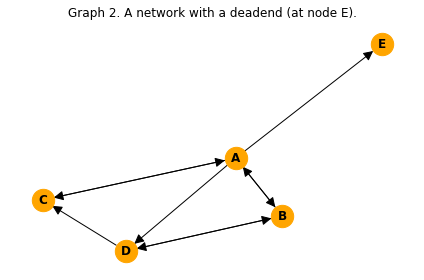

In [10]:
G2 = nx.DiGraph()
G2.add_nodes_from(["A","B","C","D","E"])
G2.add_edges_from([
    ("A","B"), ("A","C"), ("A","D"), ("A","E"), 
    ("B","A"), ("B","D"), 
    ("C","A"),    
    ("D","B"), ("D","C"),
    # no outgoing link from node E
])

plt.figure()  
plt.title("Graph 2. A network with a deadend (at node E).")
nx.draw(G2, node_size=500, node_color='orange', with_labels=True, font_weight='bold', arrowsize=20)
plt.tight_layout()
plt.show()

Consider the graph bove.  Here we see that node E does not have any outgoing links, thus E is a deadend. The problem with deadends is that it is like a sink for infornation because while it 'absorbs' PageRank scores during the iterations: it does not pass them on to other nodes. As a result, some or all the components would eventually go to zero.

To see this effect, let us edit our `transition_matrix` function to handle nodes with zero degrees. The main problem is that a division by zero error could occur when we divide $A.T$ by $d$ if  $d$ has zero values. To address this, we just set the zero values of $d$ to 1. This will not affect the resulting matrix since the corresponding column in $A.T$ will all be zeros (recall that there are no outlinks for this node.)

In [11]:
def transition_matrix(G):
    """
    Compute the Transition Matrix given a NetworkX graph
    
    Parameters
    ----------
    G : NetworkX graph
        Graph to extract the transition matrix
    Returns
    -------
    M : numpy array
        Numpy array of the transition matrix of G
    """        
    A = nx.adjacency_matrix(G).toarray()
    d = np.array([x[1] for x in list(G.out_degree)])
    
    # get indices with zero and replace them with 1 to avoid division by zero
    # this won't affect the result since the corresponding column will have all zeros
    d[d==0]=1
    
    M = A.T * (1/d)    
    return M

Let's now compute the transition matrix for Graph 2 and see what happens when we apply the Power Iteration Method.

In [12]:
M2 = transition_matrix(G2)
M2

array([[0.  , 0.5 , 1.  , 0.  , 0.  ],
       [0.25, 0.  , 0.  , 0.5 , 0.  ],
       [0.25, 0.  , 0.  , 0.5 , 0.  ],
       [0.25, 0.5 , 0.  , 0.  , 0.  ],
       [0.25, 0.  , 0.  , 0.  , 0.  ]])

First, we observe that the characteristic Matrix is no longer *stochastic* - the sum at column E is 0.

In [13]:
M2.sum(axis=0)

array([1., 1., 1., 1., 0.])

In [14]:
r = idealized_page_rank(M2)

In [15]:
np.rint(r)

array([0., 0., 0., 0., 0.])

We observe that the final values of all elements of $\textbf{v}$ are 0.

### Spider Traps

Another issue that PageRank algorithm has to face is the existence of spider traps. A spider trap is a set of nodes with no dead ends but no link out of the set of nodes comprising the spider trap. The effect on the PageRank algorithm is the opposite of deadends. Whereas in deadends information "leaks out" from the deadend, in the case of spider traps, they get accumulated.
Graph 3 shown by {numref}`spider-trap` below is an example of a network with a 1-node spider trap.

```{figure} ./images/SpiderTrap.PNG
:width: 450px
:name: spider-trap

(Graph 3): A network with a spider trap (at node E).
```

**Note**: Earlier versions of NetworkX might not show the self-loop in Node E, that's why we provided an image above. However, it can be confirmed in the transition matrix below that the self-loop exists if you look at the noting that the entry for row-column of E is 1 (M3[4,4] below).

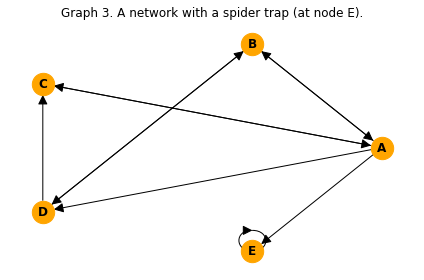

In [16]:
G3 = nx.DiGraph()
G3.add_nodes_from(["A","B","C","D","E"])
G3.add_edges_from([
    ("A","B"), ("A","C"), ("A","D"), ("A","E"), 
    ("B","A"), ("B","D"), 
    ("C","A"),    
    ("D","B"), ("D","C"),
    ("E","E"),
])

plt.figure()  
plt.title("Graph 3. A network with a spider trap (at node E).")
pos = nx.circular_layout(G3)
nx.draw(G3, pos, node_size=500, node_color='orange', with_labels=True, font_weight='bold', arrowsize=20)
plt.tight_layout()
plt.show()

In [17]:
M3 = transition_matrix(G3)
M3

array([[0.  , 0.5 , 1.  , 0.  , 0.  ],
       [0.25, 0.  , 0.  , 0.5 , 0.  ],
       [0.25, 0.  , 0.  , 0.5 , 0.  ],
       [0.25, 0.5 , 0.  , 0.  , 0.  ],
       [0.25, 0.  , 0.  , 0.  , 1.  ]])

If we compute the PageRank, we'll notice that all the traffic goes to node E.

In [18]:
r = idealized_page_rank(M3)
np.rint(r)

array([0., 0., 0., 0., 1.])

## PageRank with Taxation

A solution to the two issues we mentioned above (deadends and spider traps) is to allow each random surfer to *teleport* with a small probability $\beta$ rather than following an out-link in its current page. This method of random teleportation is called *taxation* in the textbook.

If $\textbf{e}$ is a vector of 1's of size $n$, The iteration step now becomes:

$
    \textbf{v}^{(t+1)}= \beta M\textbf{v}^{(t)} + (1-\beta)\textbf{e}/n
$



$\beta$ values are usually chosen in the range of 0.8 to 0.9. 

We create a taxed version of the PageRank below.

In [19]:
def taxed_page_rank(M, beta=0.8, tol=10**-6, max_iter=100):
    """Compute the Taxed PageRank (without Taxation) of a given Transition Matrix    
       Note that this not make use of `e` -- the vector of ones 
       since numpy's broadcasting takes care of properly computing a vector-constant addition
    Parameters
    ----------
    M : numpy array
        Transition Matrix: Array of shape (n, n), where n is the number of nodes in the network
    tol : float
        Tolerance: Iteration stops if the distance between previous and updated PageRank vectors 
        goes below this value
    max_iter : integer
        Maximum number of iterations
    Returns
    -------
    v : numpy array
        Vector of size n containing the ordinary PageRank values 
    """    
    n = M.shape[0]
    v = np.ones(n)  
    delta = 1/tol # initialize vector difference to a large number
    i = 0
    while delta > tol:
        i += 1
        prev_v = v
        v = beta*M.dot(v) + ((1-beta)/n)  
        delta = np.sum(np.abs(v-prev_v))  # compute L1 norm  
        if i >= max_iter:
            break
    return v

In [20]:
M3 = transition_matrix(G3)
taxed_page_rank(M3)

array([0.2       , 0.13333334, 0.13333334, 0.13333334, 0.40000391])

## Using PageRank in Search Engine

Google is said to use over 250 properties of pages from which the ranking is decided, among those properties, PageRank is among the important ones. The others are:
- presence of search terms
- where the search terms appear in the page (e.g. headers)
- search terms appearing in pages that link to the page in question

**EXERCISES**

1. As discussed above, Google introduced the innovation of judging the importance of a page by the terms used in the link, and not just hte links that appeared in the page. How does this defeat Term Spam?
2. Why not just count the number of inlinks to a page instead of doing PageRank?
3. Given Graph 1, remove node E and its edges then compute its PageRank. (This is the example give in Lescovec et al.'s book {cite:ps}`leskovec2020mining`).
4. Given Graph 3, remove node E and its edges then compute its Taxed PageRank. (This is the example give in Lescovec et al.'s book {cite:ps}`leskovec2020mining`).

**REFERENCE** {cite:ps}`leskovec2020mining`